In [ ]:
import functools
import os
import shutil
from typing import Any, Dict, List, Optional

from absl import app
from absl import flags
from absl import logging
import clrs
import jax
import numpy as np
import requests
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
import random

def visualise_graph(adjacency_matrix, start_node_array, bfs_path, title=""):
    """
    Visualizes a graph and its BFS traversal, highlighting the starting node and
    showing the traversal path with directed arrows.

    Args:
        adjacency_matrix: Adjacency matrix (NumPy array).
        start_node_array: Starting node indicator (NumPy array).
        bfs_path: BFS traversal path (NumPy array). bfs_path[i] = j means j is i's predecessor.

    Returns:
        None (displays the graph visualization).
    """

    # --- Input Validation --- (Same as before, included for completeness)
    if not isinstance(adjacency_matrix, np.ndarray) or adjacency_matrix.ndim != 2 or adjacency_matrix.shape[0] != adjacency_matrix.shape[1]:
        raise ValueError("adjacency_matrix must be a square 2D NumPy array.")
    if not isinstance(start_node_array, np.ndarray) or start_node_array.ndim != 1 or start_node_array.size != adjacency_matrix.shape[0]:
        raise ValueError("start_node_array must be a 1D NumPy array with the same size as the adjacency matrix dimensions.")
    if np.sum(start_node_array) != 1:
        raise ValueError("start_node_array must contain exactly one '1'.")
    if not np.all((start_node_array == 0) | (start_node_array == 1)):
        raise ValueError("start_node_array must contain only 0s and 1s")
    if bfs_path.ndim != 1 or bfs_path.size != adjacency_matrix.shape[0]:
        raise ValueError("bfs_path must be a 1D NumPy array with the same size.")
    if not np.all(bfs_path >= 0) or not np.all(bfs_path < adjacency_matrix.shape[0]):
        raise ValueError("bfs_path contains invalid node indices.")
    start_node_index = np.where(start_node_array == 1)[0][0]
    if bfs_path[start_node_index] != start_node_index:
        raise ValueError("Starting node's predecessor must be itself.")

    # --- 1. Create the graph (as a DiGraph for directed edges) ---
    num_nodes = adjacency_matrix.shape[0]
    graph = nx.DiGraph()  # Use DiGraph for directed edges
    graph.add_nodes_from(range(num_nodes))

    # Add edges for the underlying graph structure (still undirected for visualization)
    undirected_graph = nx.Graph()
    undirected_graph.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adjacency_matrix[i, j] == 1:
                undirected_graph.add_edge(i, j)


    # --- 2. Add directed edges for the BFS traversal ---
    for i in range(num_nodes):
        predecessor = bfs_path[i]
        if predecessor != i:  # Don't add self-loops
            graph.add_edge(predecessor, i)  # Add directed edge

    # --- 3. Node colors ---
    node_colors = ['skyblue'] * num_nodes
    node_colors[start_node_index] = 'red'

    # --- 4. Visualize ---
    pos = nx.spring_layout(undirected_graph)  # Use layout from the *undirected* graph

    plt.figure(figsize=(8, 6))

    # Draw the underlying undirected graph structure (without arrows)
    nx.draw_networkx_nodes(undirected_graph, pos, node_color=node_colors, node_size=800)
    nx.draw_networkx_labels(undirected_graph, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(undirected_graph, pos, edge_color='gray', width=1.0, arrows=False) # No arrows here

    # Draw the BFS traversal as directed edges (with arrows)
    nx.draw_networkx_edges(graph, pos, edge_color='red', width=2.0, arrowstyle='-|>', arrowsize=20)

    plt.title(title)
    plt.show()


NUM_SAMPLES = 1000
encode_hints = True
decode_hints = True
train_lengths = ['4', '7', '11', '13', '16']
train_lengths = [int(x) for x in train_lengths]

alg = "bfs"

rng = np.random.RandomState(42)
rng_key = jax.random.PRNGKey(rng.randint(2**32, dtype=np.int64))

# Create samplers
sampler, spec = clrs.build_sampler(
        alg,
        seed=rng.randint(2**32, dtype=np.int64),
        num_samples=NUM_SAMPLES,
        length=7,
        )

processor_factory = clrs.get_processor_factory(
    'triplet_gmpnn',
    use_ln=True,
    nb_triplet_fts=8,
    nb_heads=1,
    )
model_params = dict(
    processor_factory=processor_factory,
    hidden_dim=128,
    encode_hints=encode_hints,
    decode_hints=decode_hints,
    encoder_init='xavier_on_scalars',
    use_lstm=False,
    learning_rate=0.001,
    grad_clip_max_norm=1.0,
    checkpoint_path='checkpoints/CLRS30',
    freeze_processor=False,
    dropout_prob=0.0,
    hint_teacher_forcing=0.0,
    hint_repred_mode='soft',
    nb_msg_passing_steps=1,
    )
dummy_traj = [sampler.next()]
model = clrs.models.BaselineModel(
  spec=[spec],
  dummy_trajectory=dummy_traj,
    get_inter=True,
  **model_params
)

# feedback_list = [next(t) for t in train_samplers]

# # Initialize model.
all_features = [f.features for f in dummy_traj]
model.init(all_features, 43)

model.restore_model(f'best_{alg}.pkl', only_load_processor=False)


feedback = sampler.next()
# batch_size = feedback.outputs[0].data.shape[0]
new_rng_key, rng_key = jax.random.split(rng_key)

preds, _, hist = model.predict(new_rng_key, feedback.features)


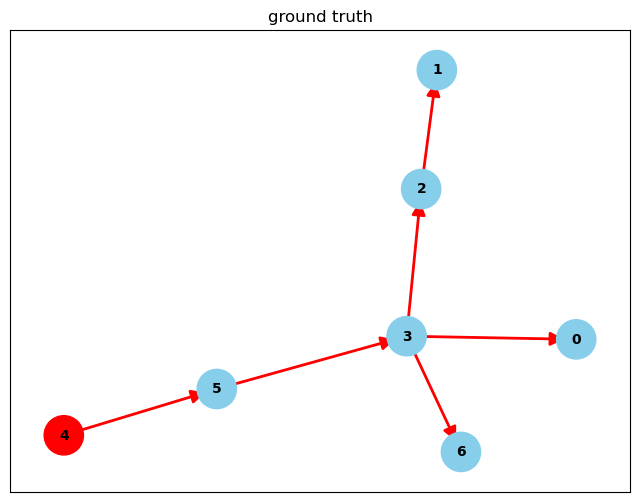

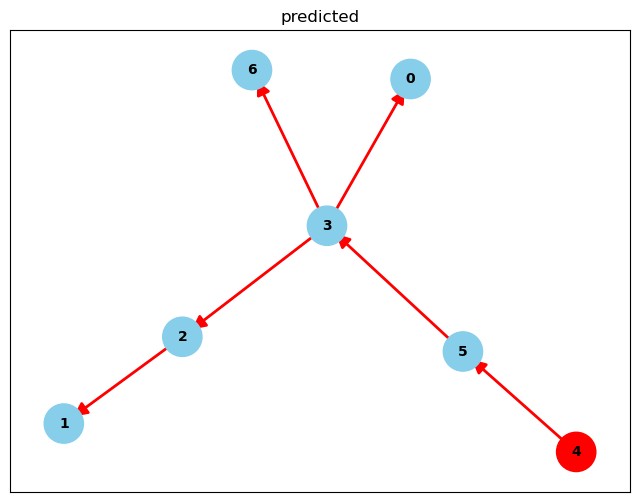

In [62]:
item = random.randint(0, NUM_SAMPLES)
adj = feedback.features.inputs[3].data[item]
start = feedback.features.inputs[1].data[item]
bfs_path = feedback.outputs[0].data[item]
pred_path = np.array(preds["pi"].data[item].astype(np.int32).tolist())
visualise_graph(adj, start, bfs_path, title="ground truth")
visualise_graph(adj, start, pred_path, title="predicted")

In [63]:
feedback.features.hints[0].data[:,item,:]

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [64]:
feedback.features.hints

[DataPoint(name="reach_h",	location=node,	type=mask,	data=Array(7, 1000, 7)),
 DataPoint(name="pi_h",	location=node,	type=pointer,	data=Array(7, 1000, 7))]

In [65]:
len(hist)

6

In [75]:
hist[4].hiddens

Array([[[ 3.34121078e-01,  9.61559862e-02, -5.84652305e-01, ...,
          3.47747350e+00, -6.97538853e-02, -6.19709343e-02],
        [ 1.99612066e-01,  1.53062105e-01, -5.68868160e-01, ...,
          3.33599281e+00, -4.80554551e-02, -3.75083126e-02],
        [ 1.73052967e-01,  4.12990786e-02, -5.69555640e-01, ...,
          3.48870659e+00, -8.14430490e-02, -3.04422453e-02],
        ...,
        [-1.30484372e-01,  1.82596259e-02, -5.26987612e-01, ...,
          3.39771724e+00, -5.54738715e-02, -1.65732335e-02],
        [-1.17520839e-01, -4.78846574e-04, -6.01140738e-01, ...,
         -6.02871180e-01, -6.18229091e-01, -6.22990549e-01],
        [-2.58127488e-02, -1.51119348e-05, -5.57273448e-01, ...,
         -5.57856619e-01, -5.73954999e-01, -5.80540776e-01]],

       [[ 1.15358857e-02,  1.78042240e-02, -6.40759051e-01, ...,
         -6.43494964e-01, -6.58430994e-01, -6.41319871e-01],
        [-6.79803127e-03, -7.05041457e-05, -5.82553089e-01, ...,
         -5.83853483e-01, -5.99532247e

In [67]:
pred_hints_reach_h = np.stack([hist[i].hint_preds['reach_h'] for i in range(6)],axis=1)

In [68]:
def softmax_rows(x):
    """Applies the softmax function to each row of a NumPy array.

    Args:
        x: A NumPy array (2D).

    Returns:
        A NumPy array with the same shape as x, where each row has been
        normalized with the softmax function (so each row sums to 1).
    """
    # Subtract the max for numerical stability (avoid overflow).
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    # Exponentiate
    exp_x = np.exp(x_shifted)
    # Sum along rows (axis=1) and keep the dimensions for broadcasting
    sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
    # Divide each element by the sum of its row
    return np.round(exp_x / sum_exp_x,1)


In [69]:
softmax_rows(pred_hints_reach_h[item])

array([[0. , 0. , 0. , 0. , 0.9, 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0.4, 0. ],
       [0. , 0. , 0. , 0.2, 0.4, 0.4, 0. ],
       [0.1, 0. , 0.1, 0.2, 0.3, 0.2, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.4, 0.2, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.4, 0.2, 0.1]], dtype=float32)